In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import TargetEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from lightgbm import LGBMClassifier

In [2]:
# Import training and test data
train_df = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')

In [3]:
# Explore data
train_df.head(10)

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP
5,5,30,59,29,Red,Pulses,10,0,9,20-20
6,6,27,62,53,Sandy,Paddy,26,15,22,28-28
7,7,36,62,44,Red,Pulses,30,12,35,14-35-14
8,8,36,51,32,Loamy,Tobacco,19,17,29,17-17-17
9,9,28,50,35,Red,Tobacco,25,12,16,20-20


In [4]:
train_df.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [6]:
train_df['Fertilizer Name'].unique()

array(['28-28', '17-17-17', '10-26-26', 'DAP', '20-20', '14-35-14',
       'Urea'], dtype=object)

In [7]:
train_df.groupby('Fertilizer Name')[['Temparature','Humidity','Moisture' ,'Phosphorous', 'Nitrogen', 'Potassium']].mean()

,Temparature,Humidity,Moisture,Phosphorous,Nitrogen,Potassium
Fertilizer Name,,,,,,
10-26-26,31.470589,60.937043,45.075856,20.980885,23.202648,9.555138
14-35-14,31.543247,60.962669,45.100047,21.410221,23.083453,9.484568
17-17-17,31.463803,60.998755,44.740345,21.053934,23.205215,9.523899
20-20,31.514406,61.104230,45.316713,21.110633,23.008441,9.590329
28-28,31.518973,61.013179,45.500297,21.024821,23.013431,9.478220
DAP,31.508065,61.155703,45.261944,20.956051,23.155977,9.252878
Urea,31.507296,61.140527,45.342743,20.926666,22.972107,9.417323


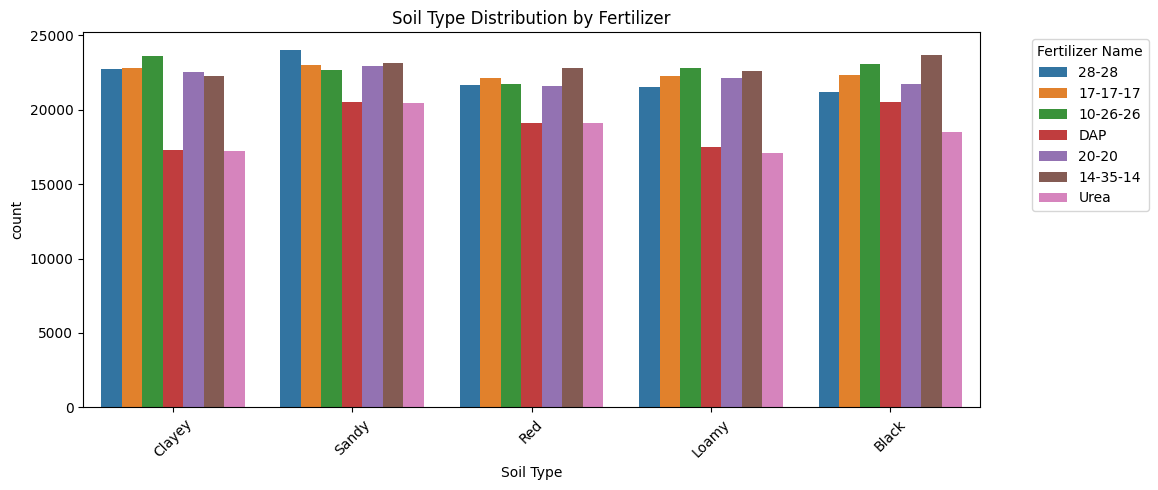

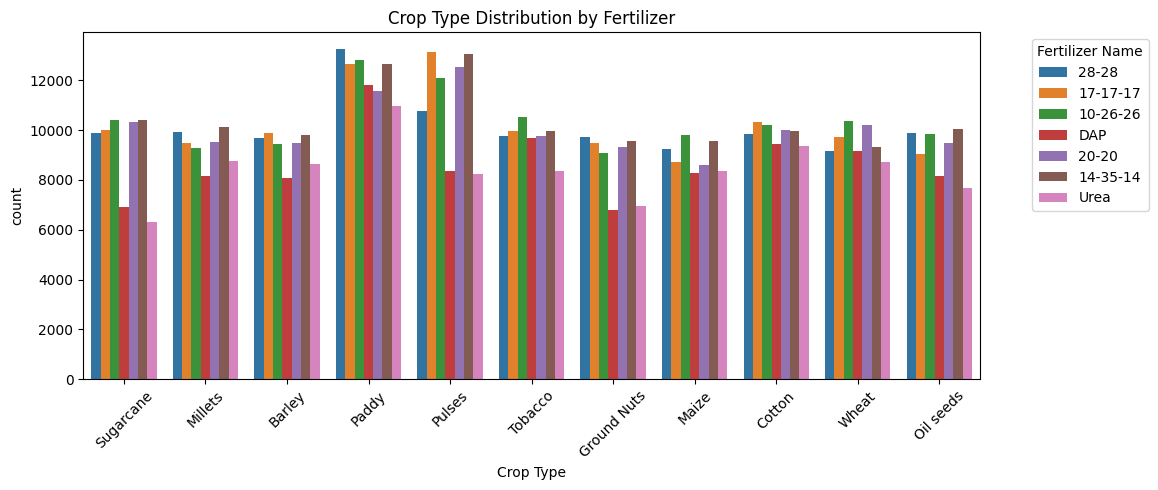

In [8]:
categorical_cols = ['Soil Type', 'Crop Type']

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=col, hue='Fertilizer Name', data=train_df)
    plt.title(f'{col} Distribution by Fertilizer')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Move legend outside
    ax.legend(title='Fertilizer Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

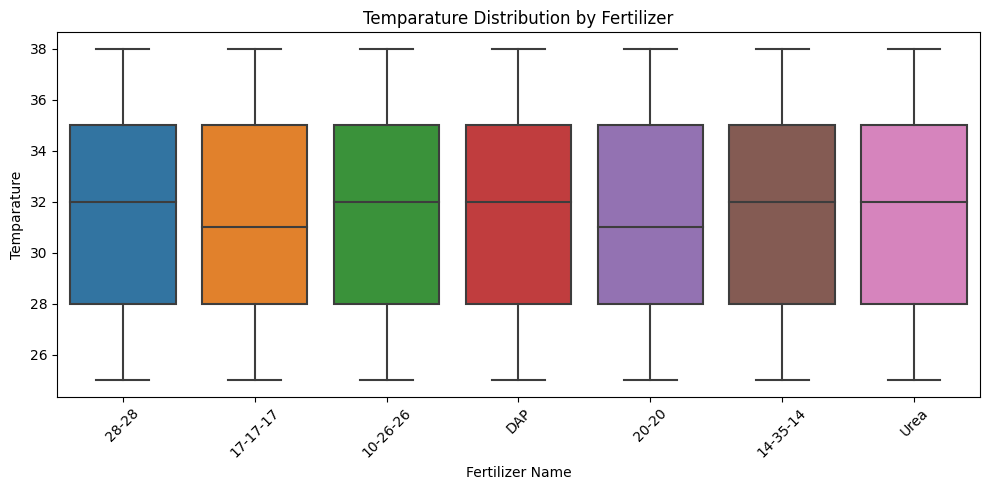

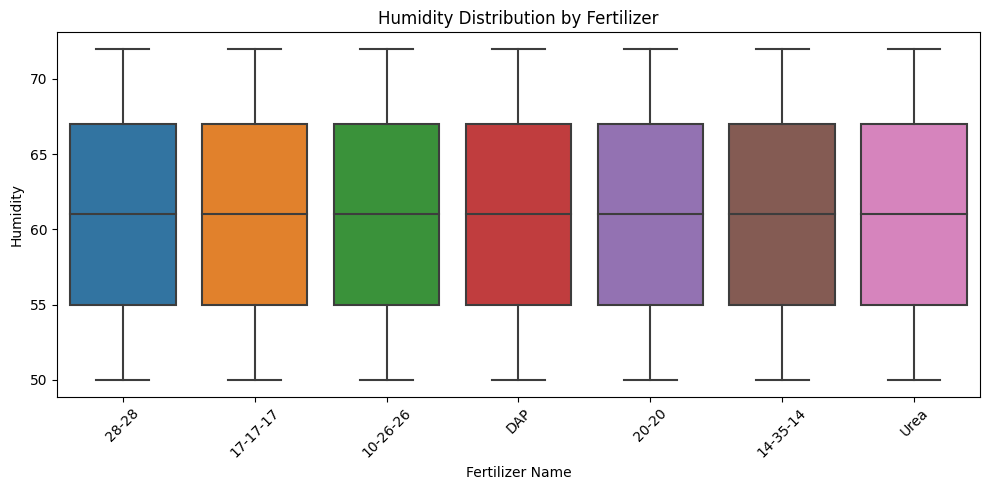

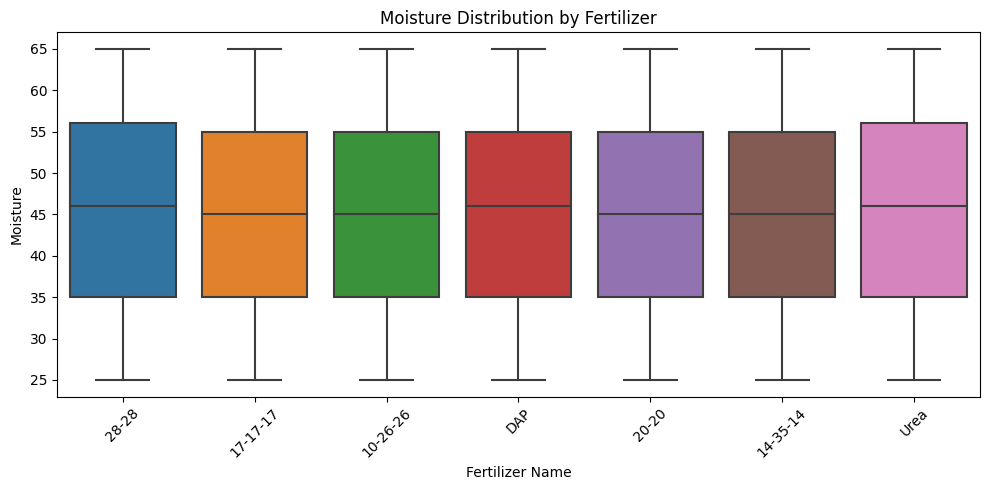

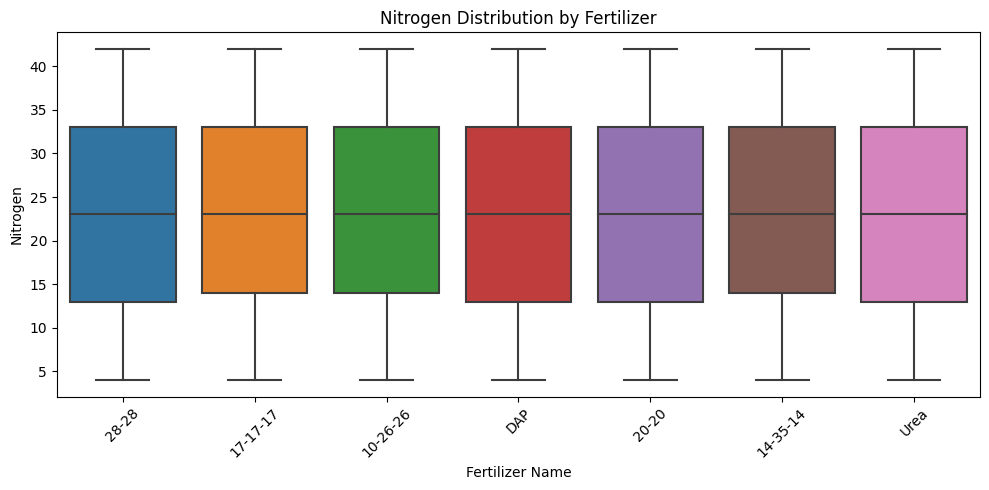

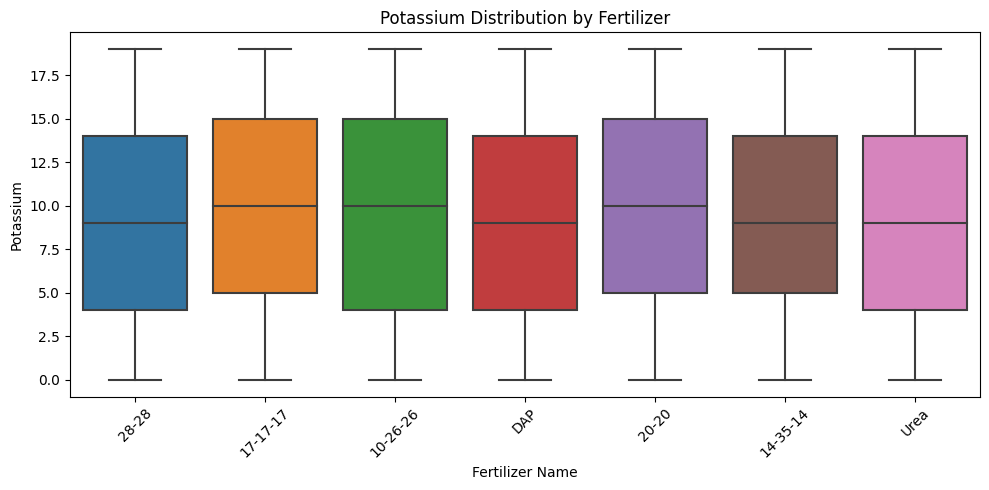

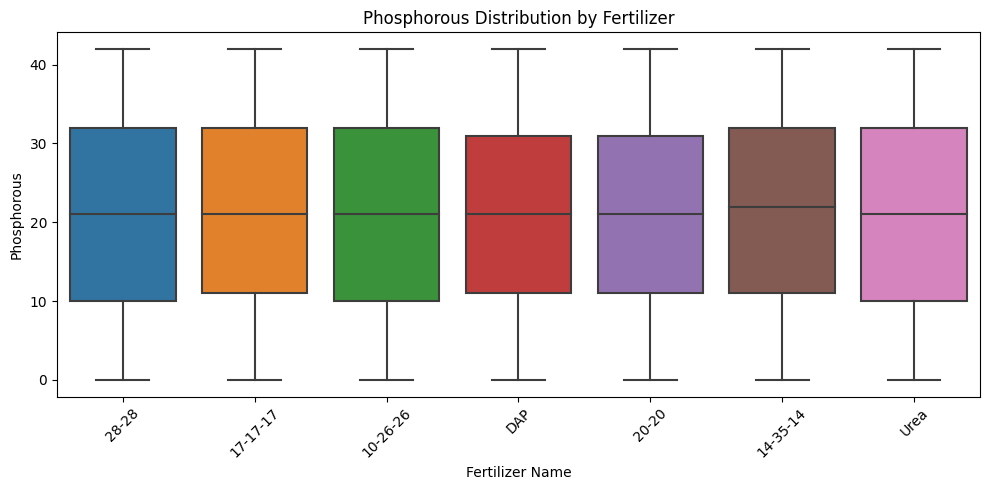

In [9]:
numerical_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Fertilizer Name', y=col, data=train_df)
    plt.title(f'{col} Distribution by Fertilizer')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


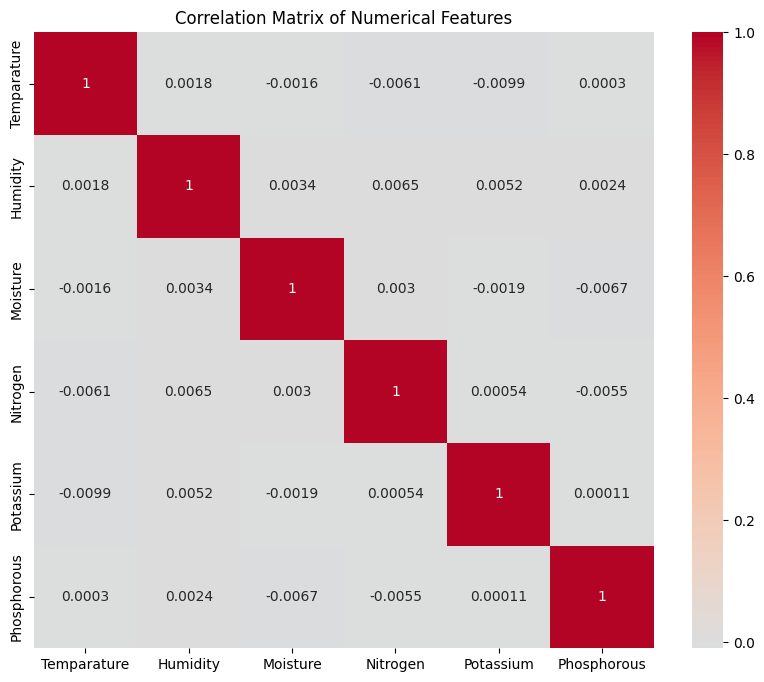

In [10]:
corr_matrix = train_df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [11]:
# Remove target from training set
X = train_df.drop('Fertilizer Name', axis=1)
y = train_df['Fertilizer Name']

In [12]:
# Encode categorical target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [13]:
# Split training data to train model
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, stratify = y, random_state = 10)

In [14]:
# Block of code to test different feature engineered groups
X_train = X_train.copy()
X_train['Soil Crop'] = X_train['Soil Type']+'_'+X_train['Crop Type']

X_test = X_test.copy()
X_test['Soil Crop'] = X_test['Soil Type']+'_'+X_test['Crop Type']

In [15]:
# Separate categorical an numerical columns for training model
te_cols = ['Soil Type','Crop Type', 'Soil Crop']
all_num_cols = [ 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

In [16]:
# Encode categorical columns 
te = TargetEncoder(cols=te_cols, smoothing=10)
X_train[te_cols] = te.fit_transform(X_train[te_cols], y_train)
X_test[te_cols] = te.transform(X_test[te_cols])

In [17]:
# Pipeline for scaling
scaler_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [18]:
# Apply scaling to numerical and target encoded categorical features
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', scaler_pipeline, all_num_cols),
    # ('te_cols', scaler_pipeline, te_cols)
],
    remainder = 'drop')

In [19]:
# Pipeline for handling preprocessing of scaling numerical and encoded features
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [20]:
# Apply preprocessing pipeline: fit on training data, transform both sets
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [21]:
# Metric function for MAP@3 calculation
def mapk_metric(y_true, y_pred_topk, k=3):
    return np.mean([
        1.0 / (pred[:k].index(true) + 1) if true in pred[:k] else 0.0
        for true, pred in zip(y_true, y_pred_topk)
    ])

# custom MAP@3 scoring function for gridsearchCV
def map3_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)  
    top_3 = np.argsort(proba, axis=1)[:, -3:][:, ::-1] 
    top_3_list = top_3.tolist()
    return mapk_metric(y, top_3_list, k=3)

In [22]:
# Model 1
lgbm = LGBMClassifier(random_state=10)

In [23]:
# These tuned parameters gave best results
param_grid_lgbm = {
    'n_estimators': [500],
    'learning_rate': [0.05],
    'num_leaves': [ 127],
    'min_data_in_leaf': [50],
    'feature_fraction': [0.6],
    'bagging_fraction': [0.8],
    'bagging_freq': [1],
    'min_gain_to_split': [0],
    'lambda_l2': [1]
}

In [24]:
# Gridsearch to find best hyperparameters with map@3 as scoring metric
lgbm_cv = GridSearchCV(lgbm, param_grid_lgbm, cv=3, scoring=map3_scorer, n_jobs=-1)

In [25]:
# Fit model
lgbm_cv.fit(X_train_processed, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ign

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=10), n_jobs=-1,
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [1],
                         'feature_fraction': [0.6], 'lambda_l2': [1],
                         'learning_rate': [0.05], 'min_data_in_leaf': [50],
                         'min_gain_to_split': [0], 'n_estimators': [500],
                         'num_leaves': [127]},
             scoring=<function map3_scorer at 0x7ab03db8c720>)

In [26]:
# Returns best parameters from GridsearchCV
lgbm_cv.best_params_

{'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.6,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'min_data_in_leaf': 50,
 'min_gain_to_split': 0,
 'n_estimators': 500,
 'num_leaves': 127}

In [27]:
# Best score from model
lgbm_cv.best_score_

0.31666888888888883

In [28]:
# Used to determine feature engineered columns with the most impact

# from sklearn.inspection import permutation_importance

# # Run permutation importance using best estimator
# result = permutation_importance(
#     lgbm_cv.best_estimator_,  
#     X_test_processed,
#     y_train,
#     n_repeats=10,
#     random_state=10,
#     n_jobs=-1
# )

# # Handle feature names: If pipeline removed names, get them manually
# try:
#     feature_names = col_trans.get_feature_names_out()
# except:
#     feature_names = [f'Feature {i}' for i in range(X_test_processed.shape[1])]

# # Create DataFrame with results
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance Mean': result.importances_mean,
#     'Importance Std': result.importances_std
# }).sort_values(by='Importance Mean', ascending=False)

# # Plot
# importance_df.head(20).plot(
#     kind='barh',
#     x='Feature',
#     y='Importance Mean',
#     xerr='Importance Std',
#     title='Top 20 Features by Permutation Importance',
#     figsize=(10, 8)
# )
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

# # get top 10 features
# top_features = importance_df.head(10)['Feature'].tolist()
# print("Top 10 Features:", top_features)

In [29]:
# Model 2
xgb = XGBClassifier(random_state=10, tree_method = 'hist')

In [30]:
# These tuned parameters gave best results
param_grid_xgb = {
    'n_estimators': [500],
    'max_depth': [8],               
    'learning_rate': [0.1],         
    'subsample': [0.8],             
    'min_child_weight': [4],        
    'colsample_bytree': [0.4],      
    'gamma': [0],       
    'lambda': [5],             
    'alpha': [1], 
}     

In [31]:
# Gridsearch to find best hyperparameters with map@3 as scoring metric
xgb_cv = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring=map3_scorer, n_jobs=-1)

In [32]:
# Fit model
xgb_cv.fit(X_train_processed, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=10, ...),
             n_jobs=-1,
             param_grid={'alpha': [1], 'colsample_bytree': [0.4], 'gamma': [0],
                         'lambda': [5], 'learning_rate': [0.1],
                         'max_depth': [8], 'min_child_weight': [4],
                         'n_estimators': [500], 'subsample': [0.8]},
             scoring=<function map3_scorer at 0x7ab03db8c720>)

In [33]:
# Returns best parameters from GridsearchCV
xgb_cv.best_params_

{'alpha': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'lambda': 5,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 500,
 'subsample': 0.8}

In [34]:
# Best score from model
xgb_cv.best_score_

0.3064147222222222

In [35]:
# Add feature engineered column, target encode, and preprocess TEST data
test_df = test_df.copy()
test_df['Soil Crop'] = test_df['Soil Type'] + '_' + test_df['Crop Type']
test_df[te_cols] = te.transform(test_df[te_cols])
test_processed = pipeline.transform(test_df)

# StratifiedKFold 5 fold cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
test_preds = np.zeros((test_processed.shape[0], len(le.classes_)))  

# Store MAP@3 scores for each fold
fold_map3_scores = []

# Train and predict for each fold then run on test set
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed, y_train)):
    print(f" Training fold {fold+1}")

    # training data
    X_train_fold = X_train_processed[train_idx]
    y_train_fold = y_train[train_idx]

    # validation data
    X_val_fold = X_train_processed[val_idx]
    y_val_fold = y_train[val_idx]

    # fit ensemble voting classifier
    model = VotingClassifier(
        estimators=[
            ('xgb', XGBClassifier(**xgb_cv.best_params_, use_label_encoder=False, eval_metric='mlogloss', verbosity=0)),
            ('lgbm', LGBMClassifier(**lgbm_cv.best_params_))
        ],
        voting='soft',
        n_jobs=-1
    )

    model.fit(X_train_fold, y_train_fold)

    # Probabilities for MAP@3
    y_val_pred_proba = model.predict_proba(X_val_fold)

    # Calculate MAP@3 of fold
    fold_map3 = map3_scorer(model, X_val_fold, y_val_fold)
    fold_map3_scores.append(fold_map3)  
    print(f"MAP@3 score for validation fold {fold+1}: {fold_map3}")
    
    # Average test predictions
    test_preds += model.predict_proba(test_processed) / 5

# Average MAP@3 for all folds
avg_score = np.mean(fold_map3_scores)
print(f"Average MAP@3 score of all folds: {avg_score}")

# Get top-3 predictions
top_3_indices = np.argsort(test_preds, axis=1)[:, -3:][:, ::-1]

# # Convert label-encoded indices of top-3 predictions back to original class labels
top_3_labels = np.array([le.inverse_transform(top_3_indices[:, i]) for i in range(3)]).T

# Format predictions into spaced strings
final_preds = [' '.join(row) for row in top_3_labels]

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'Fertilizer Name': final_preds
})

submission.to_csv('submission_simple_ensemble.csv', index=False)

 Training fold 1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gai